# Tarea 3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import datetime, timedelta
# Read csv
df = pd.read_csv('Data/PlanVital2.csv', sep=';', header=0, index_col=0)

# Cada columna a real
df = df.astype(float)
df.head()

# Sacamos los fines de semana
df['day'] = pd.to_datetime(df.index, format='%d-%m-%Y').dayofweek
df.drop(df[df['day'].isin([5,6])].index, inplace=True)
df.drop('day', axis=1, inplace=True)

# Sacamos los fondos que no usaremos 
df.drop(columns=['FONDO B', 'FONDO C', 'FONDO D'] , inplace=True)
df.head()

,FONDO A,FONDO E
Fecha,,
01-01-2015,32370.29,54351.70
02-01-2015,32317.97,54336.68
05-01-2015,32515.99,54340.52
06-01-2015,32314.83,54335.27
07-01-2015,32019.38,54331.39


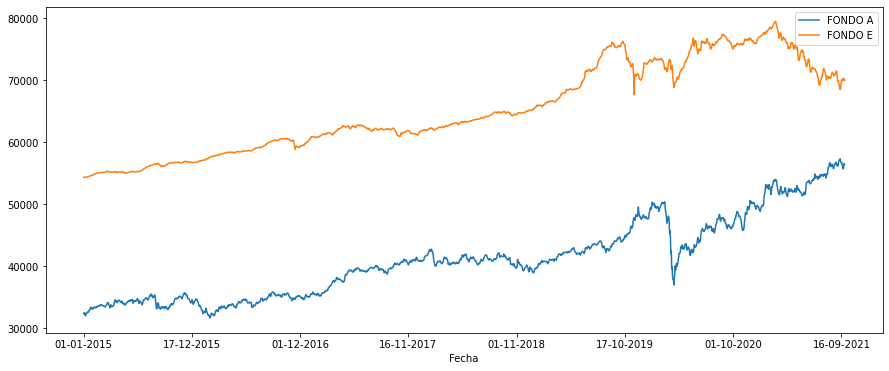

In [3]:
# Primera mirada a la evolución de los precios
df.plot(figsize=(15, 6))
plt.show()

## Cálculos preliminares

### 1. Retornos Logarítmicos

In [4]:
# Calculamos retornos logarítmicos diarios
retornos = pd.DataFrame(np.log(df.iloc[1:,:].to_numpy()/df.iloc[:-1,:].to_numpy()), columns=df.columns, index=df.index[1:])
retornos.head()

,FONDO A,FONDO E
Fecha,,
02-01-2015,-0.001618,-0.000276
05-01-2015,0.006109,0.000071
06-01-2015,-0.006206,-0.000097
07-01-2015,-0.009185,-0.000071
08-01-2015,0.003052,0.000196


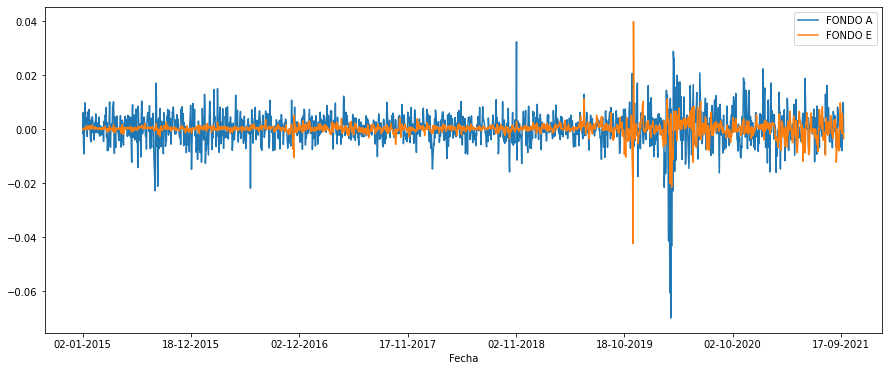

In [5]:
# Visualizamos los retornos diarios logaritmicos
retornos.plot(figsize=(15, 6))
plt.show()

<hr>
<hr>

## Parte 1

![](a.png)

Notemos que si los precios de los Fondos se pueden modelar como un MBG, entonces el logaritmo de estos, usando el lema de Ito, se puede modelar como un MBA de la siguiente forma:

$$
\delta f = \left( \mu - \frac{\sigma^2}{2} \right) \cdot \delta t + \sigma \cdot \sqrt{\delta t} \cdot \mathcal{N}(0,1)
$$

Donde $\delta f$ es simplemente $\delta ln(F)$. Podemos reescribir este modelo en versión discreta para pensar en intervalos de días:

$$
\ln(F_{t+\Delta t}) - \ln(F_{t}) = \left( \mu - \frac{\sigma^2}{2} \right) \cdot \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot \mathcal{N}(0,1)
$$

Con esto, la media de los retornos logarítmicos diarios sería justamente $\mu_A = \left( \mu - \frac{\sigma^2}{2} \right)$, mientras que la volatilidad sería $\sigma_A = \sigma$, ya que estamos hablando de intervalos de un día; es decir, $\Delta t = 1$.

In [17]:
s = retornos.std()
s

FONDO A    0.006054
FONDO E    0.002718
dtype: float64

In [18]:
mu_sigma2_2 = retornos.mean()
mu = mu_sigma2_2 + s**2/ 2
mu

FONDO A    0.000335
FONDO E    0.000147
dtype: float64

<hr>
<hr>

## Parte 2

![](b.png)

Del modelo de MBA presentado en la parte 1 podemos despejar y llegar a la siguiente expresión para el precio de un Fondo:

$$
F_{t+\Delta t} = F_t \cdot \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) \cdot \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot \mathcal{N}(0,1) \right)
$$

Luego, un paso de un mes significa un delta en días de $\Delta t = ''dias\;en\;un\;mes''$, por lo que la simulación del precio de un Fondo en el año 35 sería, tomando como precio final el último disponible en los datos y notando que la cantidad de pasos a tomar son 420, ya que es la cantidad de meses 35 años:

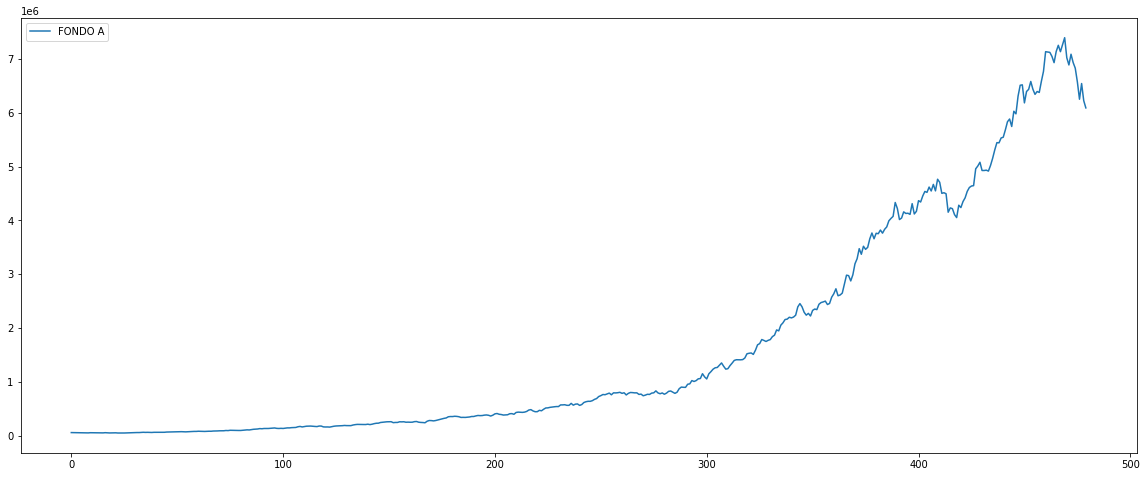

In [27]:
# Precio inicial
F_0 = df.iloc[-1,0]

# Delta meses
n_dias = retornos.shape[0]
Delta_t = n_dias // (5*12) # 5 años en la base

# Pasos
n_pasos = 12*40

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=n_pasos)

# Estdísticas del fondo A
s_A = s.iloc[0]
mu_sigma2_2_A = mu_sigma2_2.iloc[0]

# Simulación del precio recursiva
F_t = F_0 # último precio
F_35 = np.zeros(n_pasos) # precios hata el 35º paso
for t in range(n_pasos):
    F_t = F_t * np.exp(mu_sigma2_2_A * Delta_t + s_A * Delta_t**0.5 * Z[t])
    F_35[t] = F_t # Agregamos el último precio

plt.figure(figsize=(20, 8))
plt.plot(F_35, c='C0')
plt.legend(['FONDO A'])
plt.show()

Luego, tenemos que hacer lo mismo para últimos 5 años en el fondo E, tomando como precio inicial el último precio de la simulación anterior, pero con 60 pasos, que es la cantidad de meses en 5 años y las estadísticas del fondo E.

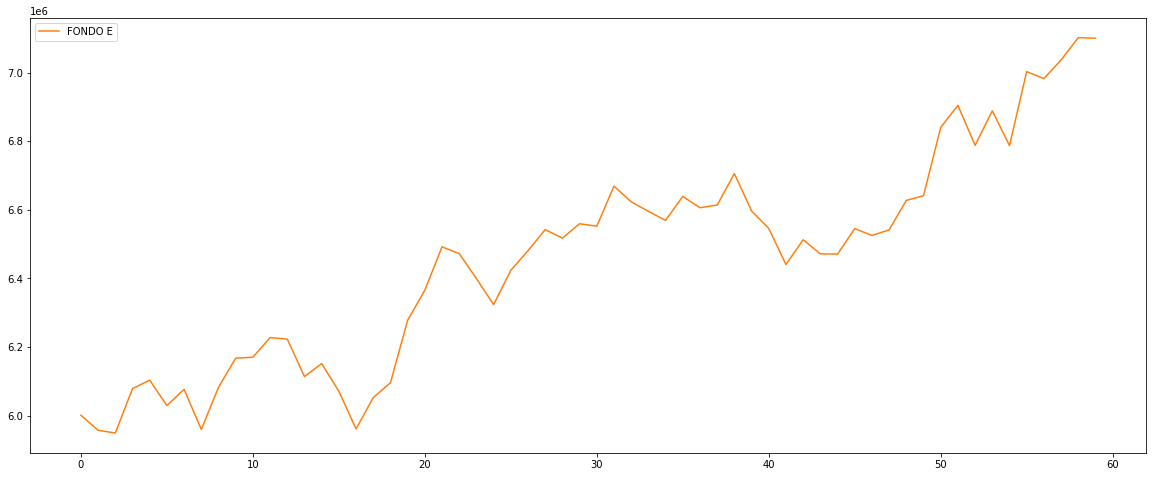

In [28]:
# Pasos
n_pasos = 60

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=n_pasos)

# Estdísticas del fondo A
s_B = s.iloc[1]
mu_sigma2_2_B = mu_sigma2_2.iloc[1]

# Simulación del precio recursiva
F_t = F_35[-1] # último precio
F_5 = np.zeros(n_pasos) # precios hata el 35º paso
for t in range(n_pasos):
    F_t = F_t * np.exp(mu_sigma2_2_B * Delta_t + s_B * Delta_t**0.5 * Z[t])
    F_5[t] = F_t # Agregamos el último precio

plt.figure(figsize=(20, 8))
plt.plot(F_5, c='C1')
plt.legend(['FONDO E'])
plt.show()

Ahora combinamos ambos resultados para la simulación de los 40 años de cotizaciones en un solo arreglo.

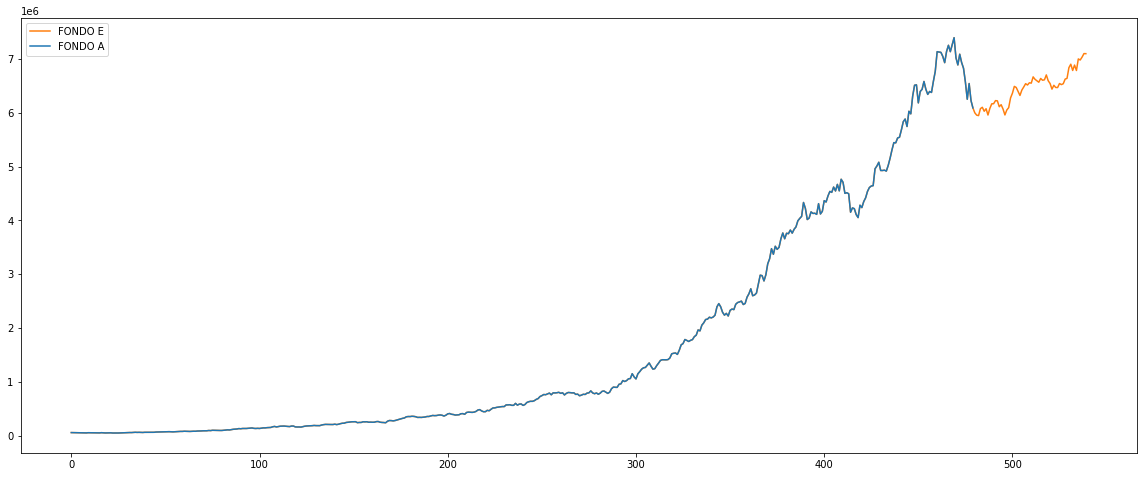

In [29]:
F_40 = np.append(F_35, F_5)

plt.figure(figsize=(20, 8))
plt.plot(F_40, c='C1', label='FONDO E')
plt.plot(F_35, c='C0', label='FONDO A')
plt.legend()
plt.show()

Repetimos el proceso $N=2000$ veces para poder generar estadísticas a partir de las simulaciones:

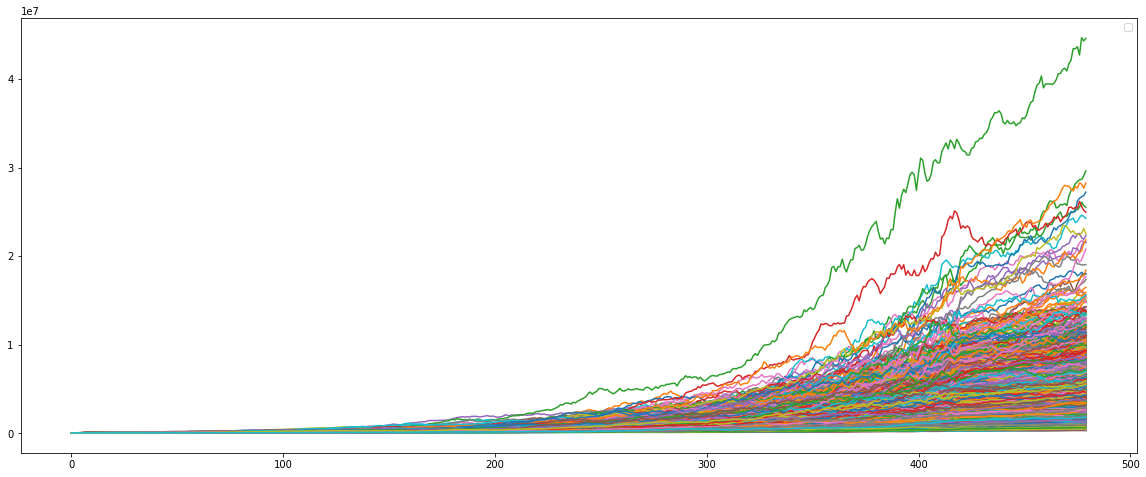

In [72]:
# Precio inicial
F_0 = df.iloc[-1,0]

# Simulaciones
N = 2000

# Delta meses
n_dias = retornos.shape[0]
Delta_t = n_dias // (5*12) # 5 años en la base

# Pasos
n_pasos = 12*40

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=(n_pasos, N))


# Simulación del precio recursiva
F_t = np.zeros(N) + F_0 # último precio
F_40 = np.zeros((n_pasos, N)) # precios hata el 35º paso
for t in range(n_pasos):
    if t <= 12*35:
        F_t = F_t * np.exp(mu_sigma2_2_A * Delta_t + s_A * Delta_t**0.5 * Z[t,:])
        F_40[t,:] = F_t # Agregamos el último precio
    else:
        F_t = F_t * np.exp(mu_sigma2_2_B * Delta_t + s_B * Delta_t**0.5 * Z[t,:])
        F_40[t,:] = F_t # Agregamos el último precio      

df_40 = pd.DataFrame(F_40)

df_40.plot(figsize=(20, 8))
plt.legend([])
plt.show()

In [73]:
# Estadísticas básicas
ultimo_F = df_40.iloc[-1,:]
ultimo_F.describe()

count    2.000000e+03
mean     4.405729e+06
std      3.463195e+06
min      3.131882e+05
25%      2.175822e+06
50%      3.442369e+06
75%      5.542519e+06
max      4.458153e+07
Name: 479, dtype: float64

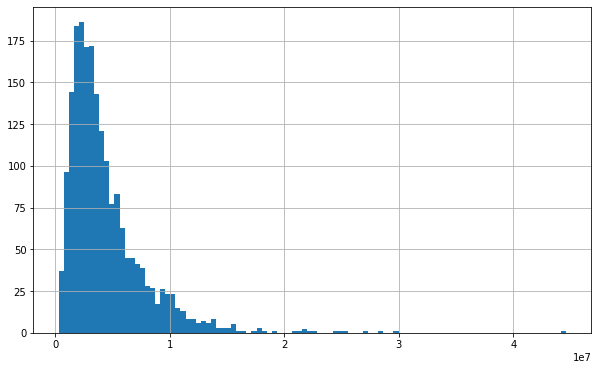

In [78]:
# Histograma
ultimo_F.hist(figsize=(10,6), bins=100)
plt.show()

In [75]:
# Quintiles
quintiles = np.round([ultimo_F.quantile(0.2*i) for i in range(1,5)],2)
quintiles

array([1907723.22, 2934428.02, 4076582.23, 6296194.96])

<hr>
<hr>

## Parte 3

![](c.png)

In [76]:
# Sueldos
sueldos = np.zeros(n_pasos)
T_3 =  12*3
sueldos[:T_3] = 1000000 

# Aumento de 100k
for t in range(T_3, n_pasos):
    if sueldos[t-1] == 2500000:
        break
    else:
        sueldos[t] = sueldos[t-1]+100000

# Se mantiene en 2.5m
sueldos[sueldos == 0] = 2500000

# 10%
aporte = sueldos*0.1

# Cuotas asignadas según el aporte
cuotas_asignadas = np.zeros((n_pasos, N))
cuotas_asignadas[0,:] = aporte[0]/df_40.iloc[0,:]
for t in range(1,n_pasos):
    cuotas_asignadas[t,:] = cuotas_asignadas[t-1,:] + aporte[t]/df_40.iloc[t,:]

# Montos capitalizados
montos_capitalizados = pd.DataFrame((cuotas_asignadas * df_40))

# Estdísticas básicas
monto_final = montos_capitalizados.iloc[-1,:]
monto_final.describe()

count    2.000000e+03
mean     1.568249e+09
std      9.259649e+08
min      2.179514e+08
25%      9.463814e+08
50%      1.340097e+09
75%      1.936486e+09
max      9.378554e+09
Name: 479, dtype: float64

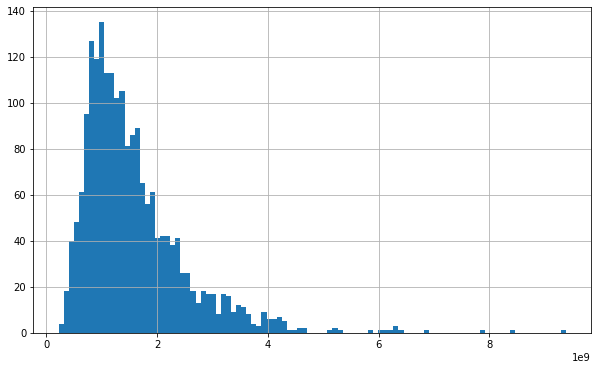

In [79]:
# Histograma
monto_final.hist(figsize=(10,6), bins=100)
plt.show()